# Metrics and Results

This notebook loads existing kit features/metrics and processes to get min-max normalized scores for analytical, cost, time, etc features for each kit. It provides useful visualizations for the feature performance of each kit.

The relevant features to consider are:

- Cost per Cell 
- Cost Equipment 
- Time 
- Maximum cell yield 
- Cell Yield 
- Gene Saturation 
- UMI saturation 
- Read Utilization 
- Gene Count 
- UMI Count
- MT fraction 
- Gene Stability 
- Celltype Distribution 
- Cluster Discrimination 
- Differential Expression 

**This notebook cannot be run with the existing data in this repo. It serves as an example of how the data was processed for our paper**

In [2]:
##Import necessary packages
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [3]:
##generic plotting parameters for paper
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams.update({'font.size': 10})
mpl.rcParams["font.family"] = "arial"

##plotting order by type
plotting_order = ['10X_3-rep1', '10X_3-rep2','10X_5-rep1', '10X_5-rep2', '10X_FRP-rep1','10X_FRP-rep2','Fluent-rep1', 'Fluent-rep2', 'Fluent-rep3', ##emulsion
                  'BD-rep1', 'BD-rep2', 'Honeycomb-rep1','Honeycomb-rep2', ##well-based
                  'Parse-rep2','Scale-rep1', ##combinatorial
                  'Scipio-rep1', 'Scipio-rep2' ] ##matrigel

In [30]:
parent_dir=##INSERT HERE
figure_dir=##INSERT HERE
supplement_dir=os.path.join(figure_dir, 'supplement')
supplement_fig_dir=os.path.join(supplement_dir, 'figures')
supplement_table_dir=os.path.join(supplement_dir, 'tables')
figure_revisions_dir= ##INSERT HERE
rev_fig_dir=os.path.join(figure_revisions_dir, 'figures')
rev_table_dir=os.path.join(figure_revisions_dir, 'tables')

##make figure directories if they doesn't exist
os.makedirs(figure_dir, exist_ok=True)
os.makedirs(supplement_fig_dir, exist_ok=True)
os.makedirs(supplement_table_dir, exist_ok=True)
os.makedirs(rev_fig_dir, exist_ok=True)
os.makedirs(rev_table_dir, exist_ok=True)

In [5]:
##read supplementary tables as dictionary of dfs
supp_excel_file=os.path.join(supplement_table_dir, 'supp_tables_revised.xlsx')
supp_excel_dfs=pd.read_excel(supp_excel_file, sheet_name=None)

In [6]:
supp_excel_dfs.keys()

dict_keys(['Table 1a CyTOF Antibody Panel', 'Table 1b CyTOF Gating Strategy', 'Table 2a Cell Recovery', 'Table2b Cell Recovery (Agg)', 'Table 3a Gene MM Model Fit', 'Table 3b UMI MM Model Fit', 'Table 4a Read Allocation', 'Table 4b Read Allocation (agg)', 'Table 5 Read Utilization', 'Table 6a Gene and UMI Median Co', 'Table 6b Gene and UMI Median Co', 'Table 7 Gene Post Hoc Dunn', 'Table 8 UMI Post Hoc Dunn', 'Table 9a Median Mito and RP %', 'Table 9b Median Mito and RP % (', 'Table 10 Post Hoc Dunn Mito', 'Table 11 Gene Summary', 'Table 12 Post Hoc Dunn Ribo', 'Table 13a Private Genes', 'Table 13b Top25-highly-expresse', 'Table 14 PC Feature Correlation', 'Table 15 Gene Stability', 'Table 16 First Pass Annotation ', 'Table 17 CyTOF Cell Proportion ', 'Table 18 Cluster Discrimination', 'Table 19 Median DEGs', 'Table 20a Cost Analysis', 'Table 20b Cost Analysis with Ti', 'Table 21 Doublet Rates'])

In [17]:
# - Cost per Cell (Table 20a; slope)
# - Cost Equipment (Table 20a; constant)
# - Time (Table 20b; time)
# - maximum cell yield (Table 2b)
# - cell yield (Table 2b)
# - gene saturation (Table 3a; Lowest RD50 and Highest Max Val; need to combine)
# - umi saturation (Table 3b; Lowest RD50 and Highest Max Val; need to combine)
# - read utilization (Table 5; Total read utilization)
# - gene umi count (Table 6b)
# - mt fraction (Table 9b)
# - gene stability (Table 15: Dropout GD50 (Low), Specificity Peak (Low))
# - celltype distribution (Table 17: Average Absolute Difference from CyTOF across all cell types 'bootstrapped_diff_from_cytof')
# - cluster discrimination (Table 18: harmonic mean)
# - differential expression (Table 19)

##Lets create a summary_df with all the kit info aggregated
req_sheets = ['Table 20a Cost Analysis', 'Table 20b Cost Analysis with Ti', 'Table2b Cell Recovery (Agg)', 
              'Table 3a Gene MM Model Fit', 'Table 3b UMI MM Model Fit', 'Table 5 Read Utilization', 'Table 6b Gene and UMI Median Co',
              'Table 9b Median Mito and RP % (', 'Table 15 Gene Stability', 'Table 17 CyTOF Cell Proportion ', 
              'Table 18 Cluster Discrimination', 'Table 19 Median DEGs']

##Merge all together by index of kit_name
summary_df = pd.concat([supp_excel_dfs[sheet].set_index('kit') for sheet in req_sheets], axis=1)

##make column names unique 
##(solution from user gbtimmon: https://stackoverflow.com/questions/40774787/renaming-columns-in-a-pandas-dataframe-with-duplicate-column-names)
class renamer():
    ##Create a dictionary for the column names
    def __init__(self):
        self.d = dict()
    ##For each column, if the column isn't present yet, create a dict entry for counts and return column name
    def __call__(self, x):
        if x not in self.d:
            self.d[x] = 0
            return x
        ##if it is present, count how many are present and return the column appended with dup count
        else:
            self.d[x] += 1
            return "%s.%d" % (x, self.d[x])

summary_df = summary_df.rename(columns=renamer())

##select only columns of interest for analysis
sel_cols = ['slope', 'constant', 'time', 'maximum_cell_recovery', 'cell_recovery_pct', 'total_umi_recovery', 'max_val', 'max_val.1',
            'median_genes', 'median_umi', 'pct_counts_mt', #'pct_counts_ribo',
            'gd50', 'CyTOF_cophenetic_dist', 'hmean', 'mean']
summary_df = summary_df[sel_cols]

##Rename columns to more useful names
rename_dict = {'slope':'cost_per_cell', 'constant':'equipment_cost', 'time':'protocol_time', 'total_umi_recovery':'read_utilization',
               'max_val':'gene_count_saturation', 'max_val.1':'umi_count_saturation',
               'median_genes':'gene_counts', 'median_umi':'umi_counts',
               'pct_counts_mt':'mt_fraction', #'pct_counts_ribo':'ribo_fraction',
               'gd50':'gene_dropout_gd50',
               'CyTOF_cophenetic_dist': 'CyTOF_similarity',
               'hmean': 'cluster_dist_hmean_score', 'mean': 'mean_nDGEs'
              }
summary_df = summary_df.rename(columns=rename_dict)
summary_df

,cost_per_cell,equipment_cost,protocol_time,maximum_cell_recovery,cell_recovery_pct,read_utilization,gene_count_saturation,umi_count_saturation,gene_counts,umi_counts,mt_fraction,gene_dropout_gd50,CyTOF_similarity,cluster_dist_hmean_score,mean_nDGEs
kit,,,,,,,,,,,,,,,
10X_3,0.16,65000,8.50,10000,98.605000,0.320607,4184.432458,17237.263265,3052.030710,9460.196065,0.050317,101.676208,0.150173,0.595188,2259.722222
10X_5,0.16,65000,8.50,10000,82.950000,0.185707,2645.528562,7534.629559,2115.170774,5463.866000,0.025896,160.633333,0.150173,0.535266,1478.611111
10X_FRP,0.17,65000,24.50,10000,91.820000,0.442232,5335.143950,26410.243620,4071.614516,12939.172194,0.002680,76.286467,0.085752,0.555966,2782.777778
Fluent,0.05,3000,14.50,20000,102.303333,0.104514,1890.570885,4106.387880,1484.035140,3077.075613,0.038442,335.185900,0.334377,0.452796,1090.666667
BD,0.08,11000,7.83,20000,70.435000,0.304093,3753.774720,17384.199835,2754.204581,8991.708710,0.145125,105.255723,0.085752,0.517527,1305.388889
Honeycomb,0.11,2000,10.50,17000,100.000000,0.088146,1209.738957,2840.242230,1188.543548,2626.555097,0.025426,412.087527,0.214062,0.218399,252.944444
Scipio,0.21,0,11.33,5000,80.890000,0.054320,828.639607,1631.085900,786.340142,1534.064578,0.010141,594.320489,0.214062,0.215413,213.055556
Parse,0.11,0,19.00,140000,122.456195,0.188089,3230.778785,9577.097879,2412.950065,5465.031097,0.004885,182.224850,0.085752,0.393826,917.875000
Scale,0.09,0,10.33,154000,83.666667,0.110105,2083.462058,3841.408501,1783.925806,3174.515355,0.002516,280.654992,0.085752,0.343622,670.375000


Now we normalize each to the 0 to 1 scale where 1 is the best possible score and 0 is the worst. For those where a lower number is better, we will need to subtract the normalized score from 1. We do this first-pass normalization so that categories that need to be combined will be weighted equally.

In [18]:
##0 to 1 normalize data
norm_summary_df = summary_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis = 0)

##define columns where a lower number is positive so we can reverse score
cols_to_reverse = ['cost_per_cell', 'equipment_cost', 'protocol_time',  'mt_fraction',
                   'gene_dropout_gd50','CyTOF_similarity', 
                  ]

##reverse the score of the reverse cols
norm_summary_df[cols_to_reverse] = norm_summary_df[cols_to_reverse].apply(lambda x: 1 - x, axis = 0)
norm_summary_df

,cost_per_cell,equipment_cost,protocol_time,maximum_cell_recovery,cell_recovery_pct,read_utilization,gene_count_saturation,umi_count_saturation,gene_counts,umi_counts,mt_fraction,gene_dropout_gd50,CyTOF_similarity,cluster_dist_hmean_score,mean_nDGEs
kit,,,,,,,,,,,,,,,
10X_3,0.3125,0.000000,0.959808,0.033557,0.541510,0.686462,0.744655,0.629811,0.689650,0.694963,0.664815,0.950988,0.740889,1.000000,0.796454
10X_5,0.3125,0.000000,0.959808,0.033557,0.240575,0.338705,0.403170,0.238246,0.404481,0.344565,0.836056,0.837179,0.740889,0.842215,0.492487
10X_FRP,0.2500,0.000000,0.000000,0.033557,0.411082,1.000000,1.000000,1.000000,1.000000,1.000000,0.998851,1.000000,1.000000,0.896723,1.000000
Fluent,1.0000,0.953846,0.599880,0.100671,0.612603,0.129396,0.235644,0.099895,0.212370,0.135291,0.748084,0.500227,0.000000,0.625061,0.341520
BD,0.8125,0.830769,1.000000,0.100671,0.000000,0.643891,0.649092,0.635740,0.598995,0.653886,0.000000,0.944078,1.000000,0.795506,0.425078
Honeycomb,0.6250,0.969231,0.839832,0.080537,0.568326,0.087200,0.084567,0.048797,0.122426,0.095790,0.839355,0.351778,0.483923,0.007861,0.015523
Scipio,0.0000,1.000000,0.790042,0.000000,0.200976,0.000000,0.000000,0.000000,0.000000,0.000000,0.946536,0.000000,0.483923,0.000000,0.000000
Parse,0.6250,1.000000,0.329934,0.906040,1.000000,0.344844,0.533038,0.320673,0.495121,0.344667,0.983389,0.795499,1.000000,0.469786,0.274278
Scale,0.7500,1.000000,0.850030,1.000000,0.254351,0.143809,0.278447,0.089201,0.303654,0.143835,1.000000,0.605492,1.000000,0.337591,0.177965


Now we will define the features of interest for evaluation and label them accordingly

In [20]:
##Make dictionary for all categories and features with new names


cat_rename = {
    'cost_per_cell': 'Cost (per Cell)',
    'equipment_cost': 'Cost (Equipment)',
    'protocol_time': 'Protocol Time',
    'cell_recovery_pct': 'Cell Yield (% of Target)',
    'maximum_cell_recovery': 'Max Cell Yield',
    'read_utilization': 'Read Utilization',
    'gene_count_saturation': 'Gene Saturation',
    'umi_count_saturation': 'UMI Saturation',
    'gene_counts': 'Genes (per Cell)',
    'umi_counts': 'UMIs (per Cell)',
    'mt_fraction': 'Mito QC',
    'gene_dropout_gd50': 'Gene Expression Stability',
    'CyTOF_similarity': 'CyTOF Similarity',
    'cluster_dist_hmean_score': 'Cluster Discrimination',
    'mean_nDGEs': "Differential Expression"
}

summary_cat_scores = norm_summary_df.rename(columns=cat_rename)

#### <center> Gridded Bubble Plots With Dendrogram

Gridded bubble plots with a dendrogram can be used to visualize the continuous feature scores of relevant kit featuers while coloring by technology type. This will enable comparison of kit performance across the relevant featuers. To get the col order we will do a clustermap first to get formatting similar to a clustermap

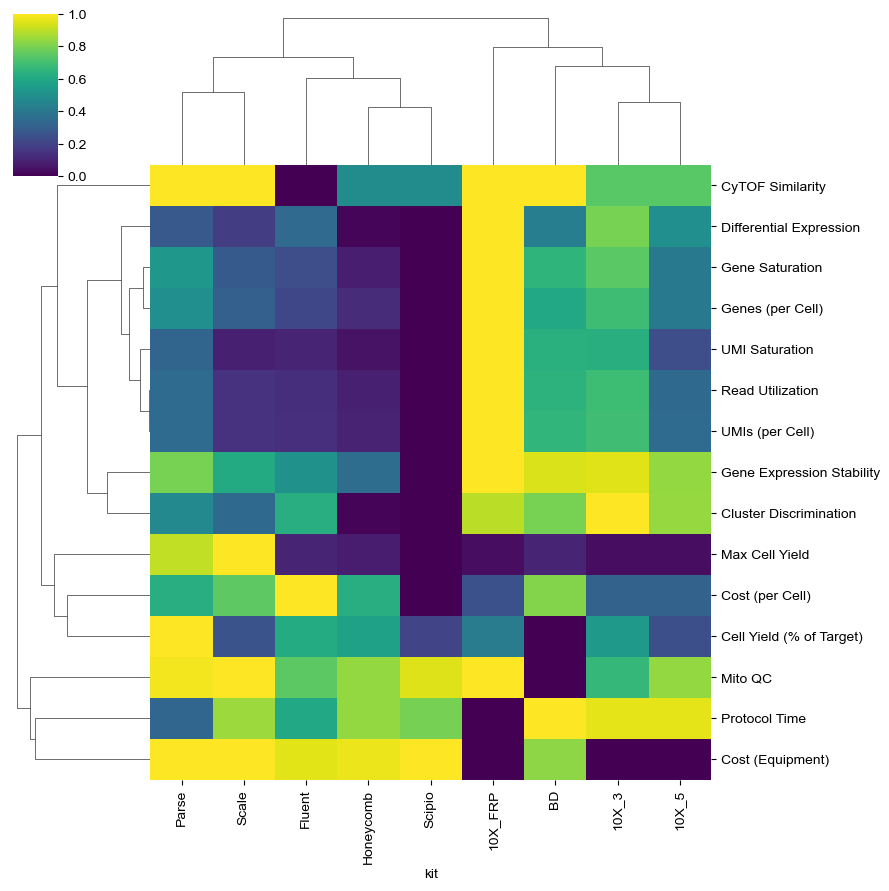

In [26]:
# Get clustermap so that we can mimic the structure of a clustermap heatmap
clustergrid = sns.clustermap(summary_cat_scores_plot, cmap='viridis', figsize=(9,9))

# Get the row and column orderings from clustermap dendrogram
row_order = reversed(clustergrid.dendrogram_row.reordered_ind)
col_order = clustergrid.dendrogram_col.reordered_ind

# Reorder the DataFrame
summary_cat_scores_reordered = summary_cat_scores_plot.iloc[row_order, col_order]

# Get non-zero minimum value for bubble plot minimum
nonzero_min = summary_cat_scores_reordered[summary_cat_scores_reordered != 0].min().min()

# Define minimum as 10% of nonzero min and replace zero values with bubble_min
bubble_min = 0.6 * nonzero_min
summary_cat_scores_reordered[summary_cat_scores_reordered == 0] = bubble_min

Color by technology group and size by value

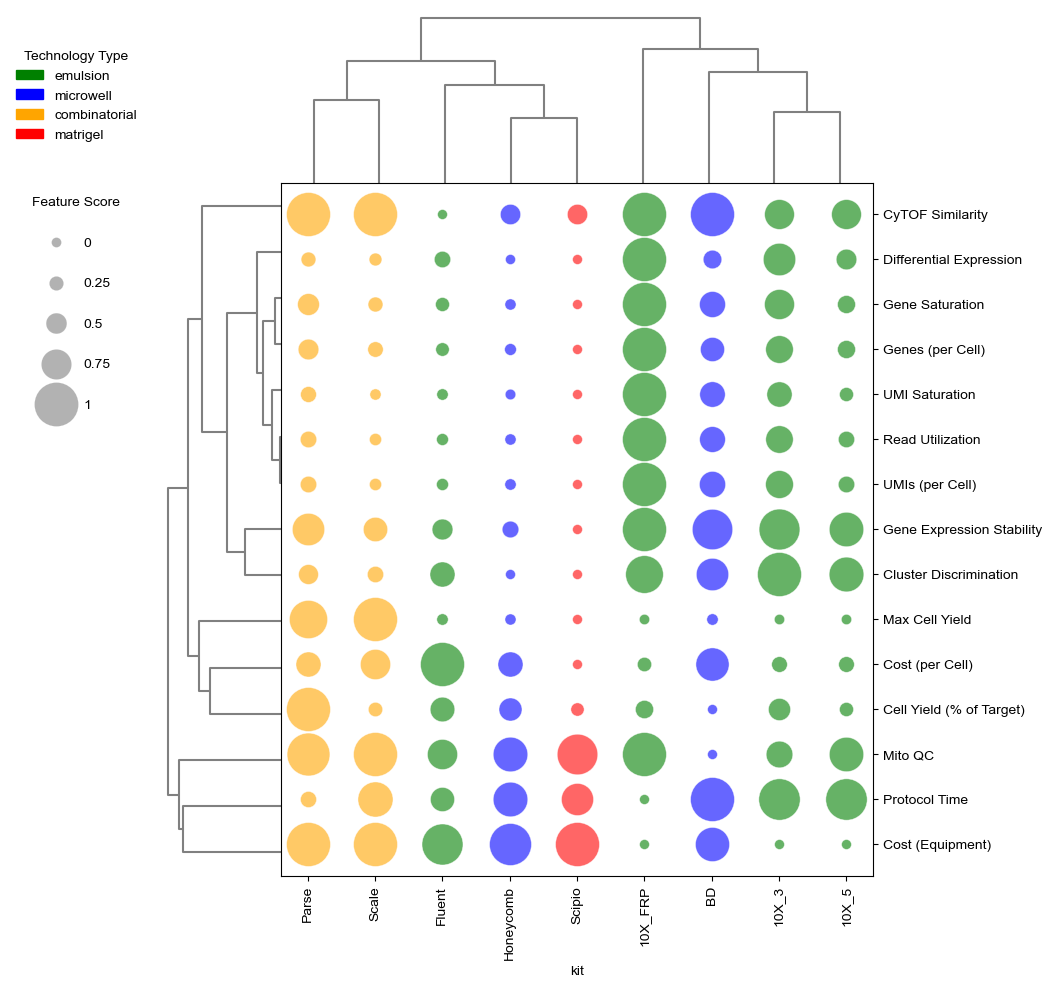

In [53]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Define dict to map kit to tech group
technology_group_dict = {'10X_3': 'emulsion', '10X_5': 'emulsion', '10X_FRP': 'emulsion', 'Fluent': 'emulsion',
                         'BD': 'microwell', 'Honeycomb': 'microwell', 
                         'Parse': 'combinatorial', 'Scale': 'combinatorial',
                         'Scipio': 'matrigel'
                        }

# Define dict to define tech group colors
technology_group_colors = {'emulsion': 'green', 'microwell': 'blue', 'combinatorial': 'orange', 'matrigel': 'red'}

# Get linkage from clustermap
row_linkage = clustergrid.dendrogram_row.linkage
col_linkage = clustergrid.dendrogram_col.linkage

# Create the figure and gridspec
fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(3, 5, width_ratios=[0.5, 1.2, 2, 10, 2], height_ratios=[1.5, 6, 0.5], hspace=0, wspace=0)

# Create the dendrogram for rows
ax_dendro_row = fig.add_subplot(gs[1, 2])
dendrogram(row_linkage, orientation='left', ax=ax_dendro_row, no_labels=True, 
           color_threshold=0, above_threshold_color='grey')
ax_dendro_row.invert_yaxis() ##need to invert because we reversed the ordering earlier to match clustermap output

# Create the dendrogram for columns
ax_dendro_col = fig.add_subplot(gs[0, 3])
dendrogram(col_linkage, ax=ax_dendro_col, no_labels=True,
           color_threshold=0, above_threshold_color='grey')
ax_dendro_col

# Create the bubble plot
max_size=50
exp_base=20
ax_bubble = fig.add_subplot(gs[1, 3])
for i, (feature, row) in enumerate(summary_cat_scores_reordered.iterrows()):
    for j, (kit, value) in enumerate(row.items()):
        tech_group = technology_group_dict[kit]
        tech_group_color = technology_group_colors[tech_group]
        size=exp_base**value * max_size
        ax_bubble.scatter(j, i, s=size, color=tech_group_color, alpha=0.6, edgecolors="w", linewidth=0.5)

# Set the ticks and labels
ax_bubble.set_xticks(range(len(summary_cat_scores_reordered.columns)))
ax_bubble.set_xticklabels(summary_cat_scores_reordered.columns, rotation=90)
ax_bubble.set_yticks(range(len(summary_cat_scores_reordered.index)))
ax_bubble.set_yticklabels(summary_cat_scores_reordered.index)
ax_bubble.yaxis.tick_right()
ax_bubble.set_xlabel('kit')

# Hide the spines and ticks for the dendrograms
ax_dendro_row.spines['top'].set_visible(False)
ax_dendro_row.spines['right'].set_visible(False)
ax_dendro_row.spines['bottom'].set_visible(False)
ax_dendro_row.spines['left'].set_visible(False)
ax_dendro_row.set_xticks([])
ax_dendro_row.set_yticks([])

ax_dendro_col.spines['top'].set_visible(False)
ax_dendro_col.spines['right'].set_visible(False)
ax_dendro_col.spines['bottom'].set_visible(False)
ax_dendro_col.spines['left'].set_visible(False)
ax_dendro_col.set_xticks([])
ax_dendro_col.set_yticks([])

# Add a legend for the technology groups
ax_legend = fig.add_subplot(gs[0, 0])
ax_legend.axis('off')  # Hide the axis

# Create legend patches
legend_patches = [mpatches.Patch(color=color, label=group) for group, color in technology_group_colors.items()]
ax_legend.legend(handles=legend_patches, loc='center', frameon=False, title='Technology Type')

# Add a legend for bubble sizes
ax_size_legend = fig.add_subplot(gs[1, 0])
ax_size_legend.axis('off')  # Hide the axis

# Create legend entries for different bubble sizes
sizes = [max_size * (exp_base**val) for val in [bubble_min, 0.25, 0.5, 0.75, 1]]
size_labels = ["0", '0.25', '0.5', '0.75', '1']
size_patches = [plt.scatter([], [], s=size, color='grey', alpha=0.6, edgecolors="w", linewidth=0.2) for size in sizes]
ax_size_legend.legend(size_patches, size_labels, loc='upper center', frameon=False, title='Feature Score',
                      handletextpad=1, labelspacing=2, borderpad=0.5)

#Save the figure
bubble_plot_file=os.path.join(rev_fig_dir, 'Gridded_BubblePlot_Dendrogram.pdf')
plt.savefig(bubble_plot_file, format='pdf', bbox_inches='tight')

plt.show()

It's clear that BD and the 10X kits overall seem to have the best analytical performance (10X FRP is the best followed by 10X_3 and 10X_5 and then BD). The remaining kits seem to be dominated by low equipment costs. The combinatorial kits also clearly have high max cell throughputs. 